## <center>Курсовой проект по предмету "Библиотеки Python для Data Science: продолжение"<center>
    ноябрь 2019 года

**Задача**

Требуется на основании имеющихся данных о клиентах банка построить модель, используя обучающий датасет для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Data input

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import re
import copy
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from xgboost.sklearn import XGBClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'

In [3]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

### Processing of missing values

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

#### Change data type

In [5]:
def list_of_object_columns(df):
    lst = list(df.columns)
    cols = []
    for i in lst:
        if df[i].dtype == 'object':
            cols.append(i)
    for j in cols:
        df[j] = df[j].astype('str')
    return cols

In [6]:
list_of_object_columns(df_train)

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Data changing in column 'Years in current job'

In [7]:
def change_years_in_current_job(df):
    for i in range(len(df['Years in current job'])):
        s = df['Years in current job'][i]
        if s is not None:
            if re.match('^\D', s):
                s = '0'
            elif re.match('^\d+', s):
                s = re.findall('^\d+', s)[0]
            df['Years in current job'][i] = s
    df['Years in current job'] = df['Years in current job'].astype(int)

In [8]:
change_years_in_current_job(df_train)
df_train['Years in current job'].value_counts()

10    2332
0      934
2      705
3      620
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

#### Filling in the missing data

In [9]:
def list_fillna_columns(df):
    a = df.isna().any()
    list_of_columns = []
    for i in range(len(a)):
        if a[i]:
            list_of_columns.append(a.index[i])
    return list_of_columns

In [10]:
list_of_columns = list_fillna_columns(df_train)
list_of_columns

['Annual Income',
 'Months since last delinquent',
 'Bankruptcies',
 'Credit Score']

Filling in the missing data from null_list by nulls

In [11]:
null_list = ['Months since last delinquent', 'Bankruptcies', 'Credit Score']

In [12]:
def rest(list_of_columns, null_list):
    rest_columns = []
    for i in list_of_columns:
        if i not in null_list:
            rest_columns.append(i)
    return rest_columns

Filling in the missing data from rest columns by mode or median

In [13]:
rest_columns = rest(list_of_columns, null_list)
rest_columns

['Annual Income']

In [14]:
def fillna_columns(df, rest_columns, null_list):
    for j in null_list:
        df.loc[df[j].isnull(), j] = 0
    for i in rest_columns:
        if type(df[i]) == 'float' or type(df[i]) == 'int':
            median_i = df.loc[~df[i].isnull(), i].median()
            df.loc[df[i].isnull(), i] = median_i
        else:
            df.loc[df[i].isnull(), i] = df[i].mode()[0]

In [15]:
fillna_columns(df_train, rest_columns, null_list)

### Overview of numerical features and pruning of insubstantial values

In [16]:
TARGET = 'Credit Default'

In [17]:
MAIN_COLS = list(df_train.columns)
MAIN_COLS.remove(TARGET)

NUM_MAIN_COLUMNS = []

for i in MAIN_COLS:
    if df_train[i].dtype == 'float' or df_train[i].dtype == 'int':
        NUM_MAIN_COLUMNS.append(i)

In [18]:
features = pd.DataFrame(columns=['features', 'Q1', 'Q3'])
for i in range(len(NUM_MAIN_COLUMNS)):
    features.loc[i] = {'features': NUM_MAIN_COLUMNS[i], 'Q1': round(np.quantile(df_train[NUM_MAIN_COLUMNS[i]], .25)), 'Q3': round(np.quantile(df_train[NUM_MAIN_COLUMNS[i]], .75))}
features

,features,Q1,Q3
0,Annual Income,931133.0,1499974.0
1,Years in current job,2.0,10.0
2,Tax Liens,0.0,0.0
3,Number of Open Accounts,8.0,14.0
4,Years of Credit History,14.0,22.0
5,Maximum Open Credit,279230.0,793502.0
6,Number of Credit Problems,0.0,0.0
7,Months since last delinquent,0.0,29.0
8,Bankruptcies,0.0,0.0
9,Current Loan Amount,180169.0,519882.0


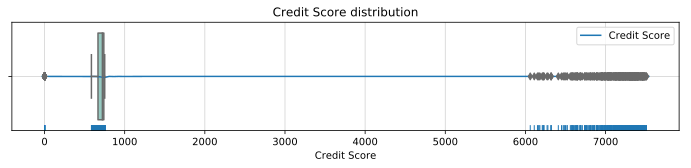

10%: 0.0 
90%: 748.0
**************************************************
1. 0-751: 7040 values, 93.87%
2. 751-1502: 60 values, 0.80%
3. 1502-2253: 0 values, 0.00%
4. 2253-3004: 0 values, 0.00%
5. 3004-3755: 0 values, 0.00%
6. 3755-4506: 0 values, 0.00%
7. 4506-5257: 0 values, 0.00%
8. 5257-6008: 0 values, 0.00%
9. 6008-6759: 54 values, 0.72%
10. 6759-7510: 344 values, 4.59%


In [19]:
j = 12
#-------------
col = NUM_MAIN_COLUMNS[j]
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.kdeplot(df_train[col])
sns.rugplot(df_train[col]);
sns.boxplot(x=df_train[col], palette="Set3")
plt.title(f'{col} distribution');
plt.grid(color='lightgrey')
fig.set_size_inches(12, 2)
plt.show()
#---------------
n = 10
max_val = df_train[col].max()
min_val = df_train[col].min()
step = round((max_val - min_val)/n) if round((max_val - min_val)/n) > 0 else 1
num = 1
print(f'10%: {round(np.quantile(df_train[col], .10))} \n90%: {round(np.quantile(df_train[col], .90))}' )
print(50*'*')
total_val = df_train[col].value_counts().sum()
for i in range(round(min_val), round(max_val), step):
    low_limit = i
    high_limit = i + step
    count_val = df_train.loc[(df_train[col] >= low_limit) & (df_train[col] < high_limit), col].value_counts().sum()
    print(f'{num}. {low_limit}-{high_limit}: {count_val} values, {count_val*100/total_val:.2f}%')    
    num += 1

In [20]:
dict_of_pruning_values = {0:4000000, 3:26, 4:34, 5:1300000, 7:84, 10:1300000, 11:55000}

def values_pruning(df, NUM_MAIN_COLUMNS, dict_of_pruning_values):
    for i in list(dict_of_pruning_values.keys()):
        df.loc[df[NUM_MAIN_COLUMNS[i]] >= dict_of_pruning_values[i], NUM_MAIN_COLUMNS[i]] = dict_of_pruning_values[i]
        print(f'Column "{NUM_MAIN_COLUMNS[i]}" was pruned higher of {dict_of_pruning_values[i]}')
        
values_pruning(df_train, NUM_MAIN_COLUMNS, dict_of_pruning_values)

Column "Annual Income" was pruned higher of 4000000
Column "Number of Open Accounts" was pruned higher of 26
Column "Years of Credit History" was pruned higher of 34
Column "Maximum Open Credit" was pruned higher of 1300000
Column "Months since last delinquent" was pruned higher of 84
Column "Current Credit Balance" was pruned higher of 1300000
Column "Monthly Debt" was pruned higher of 55000


### Dummies

In [21]:
df_train = pd.get_dummies(df_train)

### Target analyze

In [22]:
df_train[TARGET].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [23]:
MAIN_COLUMNS = list(df_train.columns)
MAIN_COLUMNS.remove(TARGET)

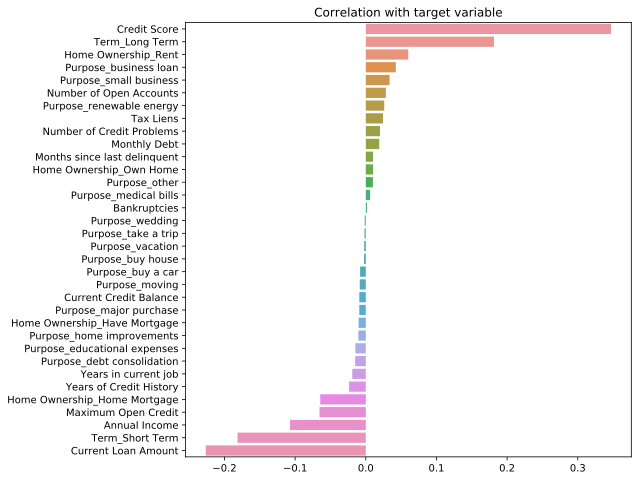

In [24]:
corr_with_target = df_train[MAIN_COLUMNS + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

### Cut-off level of features correlation

In [25]:
n = (np.abs(corr_with_target) > 0.01) 
substential_features = list(n[n == True].index)
substential_features

['Credit Score',
 'Term_Long Term',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_small business',
 'Number of Open Accounts',
 'Purpose_renewable energy',
 'Tax Liens',
 'Number of Credit Problems',
 'Monthly Debt',
 'Months since last delinquent',
 'Home Ownership_Own Home',
 'Purpose_other',
 'Home Ownership_Have Mortgage',
 'Purpose_home improvements',
 'Purpose_educational expenses',
 'Purpose_debt consolidation',
 'Years in current job',
 'Years of Credit History',
 'Home Ownership_Home Mortgage',
 'Maximum Open Credit',
 'Annual Income',
 'Term_Short Term',
 'Current Loan Amount']

In [26]:
len(MAIN_COLUMNS), len(substential_features)

(34, 24)

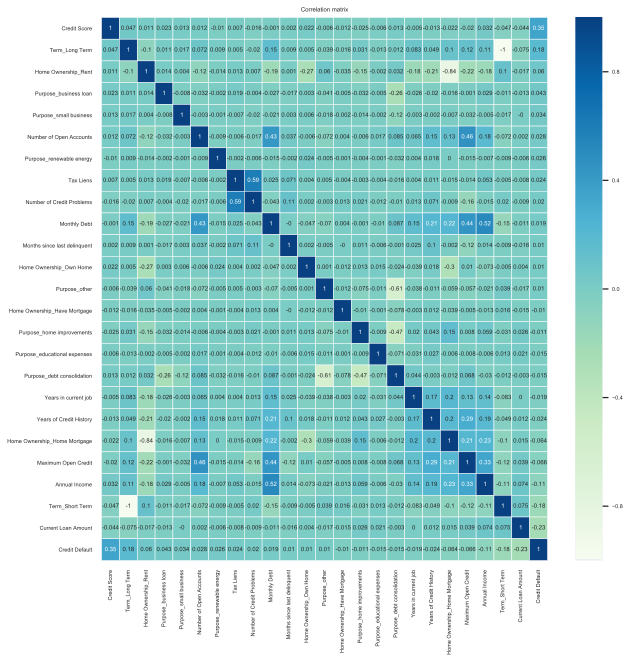

In [27]:
plt.figure(figsize = (10,10))

sns.set(font_scale=0.5)
sns.heatmap(df_train[substential_features + [TARGET]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

The graph shows that the feature 'Term_Short Term' strongly correlates with 'Term_Long Term' and 'Home Ownership_Rent' with 'Home Ownership_Home Mortgage' and at the same time 'Term_Long Term' and 'Home Ownership_Home Mortgage' have a slightly higher absolute value of correlation's coefficient with target than 'Term_Short Term' and 'Home Ownership_Rent', respectively.
##### Conclusion: 
reduce the number of significant features in the 'substential_features' list to 'Term_Short Term' and 'Home Ownership_Rent'

#### Final var. of substential features

In [28]:
substential_features.remove('Term_Short Term')
substential_features.remove('Home Ownership_Rent')
substential_features

['Credit Score',
 'Term_Long Term',
 'Purpose_business loan',
 'Purpose_small business',
 'Number of Open Accounts',
 'Purpose_renewable energy',
 'Tax Liens',
 'Number of Credit Problems',
 'Monthly Debt',
 'Months since last delinquent',
 'Home Ownership_Own Home',
 'Purpose_other',
 'Home Ownership_Have Mortgage',
 'Purpose_home improvements',
 'Purpose_educational expenses',
 'Purpose_debt consolidation',
 'Years in current job',
 'Years of Credit History',
 'Home Ownership_Home Mortgage',
 'Maximum Open Credit',
 'Annual Income',
 'Current Loan Amount']

### Feature standardization

In [29]:
df_train[substential_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 22 columns):
Credit Score                    7500 non-null float64
Term_Long Term                  7500 non-null uint8
Purpose_business loan           7500 non-null uint8
Purpose_small business          7500 non-null uint8
Number of Open Accounts         7500 non-null float64
Purpose_renewable energy        7500 non-null uint8
Tax Liens                       7500 non-null float64
Number of Credit Problems       7500 non-null float64
Monthly Debt                    7500 non-null float64
Months since last delinquent    7500 non-null float64
Home Ownership_Own Home         7500 non-null uint8
Purpose_other                   7500 non-null uint8
Home Ownership_Have Mortgage    7500 non-null uint8
Purpose_home improvements       7500 non-null uint8
Purpose_educational expenses    7500 non-null uint8
Purpose_debt consolidation      7500 non-null uint8
Years in current job            7500 non-null int

In [30]:
def change_type(df):
    cols = []
    for i in df.columns:
        if df[i].dtype == 'uint8' or df[i].dtype == 'int':
            cols.append(i)
    for j in cols:
        df[j] = pd.Categorical(df[j])
    return df
        
df_train = change_type(df_train)

In [31]:
numerical_columns_full = []
categorical_columns_full = []
numerical_columns_short = []
categorical_columns_short = []

for i in df_train[substential_features].columns:
    if df_train[i].dtype == 'float' or df_train[i].dtype == 'int':
        numerical_columns_short.append(i)
    else:
        categorical_columns_short.append(i)
        
for i in df_train.columns:
    if df_train[i].dtype == 'float' or df_train[i].dtype == 'int':
        numerical_columns_full.append(i)
    else:
        categorical_columns_full.append(i)

#### Preparing 2 lists of columns: full (just in case) and short (substantial)

In [32]:
short_feature_list = numerical_columns_short + categorical_columns_short
full_feature_list = numerical_columns_full + categorical_columns_full

#### Standardization of features only from numerical_columns_short (good correlating with target)

In [33]:
scaler = StandardScaler()

def standardization(df_train, substential_features, numerical_columns_short):
    df_norm = copy.deepcopy(df_train[substential_features])
    df_norm[numerical_columns_short] = scaler.fit_transform(df_norm[numerical_columns_short])
    return df_norm

df_norm = standardization(df_train, substential_features, numerical_columns_short)

In [34]:
with open('./data/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

### Train-test split

In [35]:
X = df_norm[short_feature_list]
y = df_train[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=43)

In [36]:
y_train.value_counts()

0    3795
1    1455
Name: Credit Default, dtype: int64

### Balancing of classes

In [37]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_for_balancing[TARGET].value_counts()

0    3795
1    1455
Name: Credit Default, dtype: int64

In [38]:
def balance_df_by_target(df, target):

    target_count = df[target].value_counts()

    major_class_name = target_count.argmax()
    minor_class_name = target_count.argmin()
    target_count = pd.DataFrame(target_count)
    A = target_count.iloc[major_class_name, :][0]
    B = target_count.iloc[minor_class_name, :][0]
    
    disbalance_coeff = int(A/B) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target] == minor_class_name].sample(B)
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [39]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET)

In [40]:
df_balanced[TARGET].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

##### Because of pd.Series format is not fit for some kind of models, y_train was formatted by ravel

In [41]:
X_train = df_balanced.drop(columns=TARGET)
y_train = df_balanced[TARGET]
y_train = np.ravel(y_train)

### Baseline

In [42]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print(f"f1_train = {f1_score(y_train, y_train_pred, average=None)[1]*100:.2f}%, \n"
    f"f1_test = {f1_score(y_test, y_test_pred, average=None)[1]*100:.2f}%")
    print(30*'*')
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

##### Logistic regression

In [43]:
%%time
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 59.22%, 
f1_test = 51.50%
******************************
CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1287  305
1                324  334
Wall time: 630 ms


##### KNN

In [44]:
%%time
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 76.08%, 
f1_test = 45.96%
******************************
CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1231  361
1                354  304
Wall time: 1.18 s


##### XGBoost

In [45]:
def category_to_int(X, category_list):
    for i in category_list:
        X[i] = X[i].astype('int')

category_to_int(X_train, categorical_columns_short)
category_to_int(X_test, categorical_columns_short)

In [46]:
%%time
model_xgb = xgb.XGBClassifier(random_state=21) 
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 67.08%, 
f1_test = 53.17%
******************************
CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1336  256
1                327  331
Wall time: 1.29 s


##### LightGBoost

In [47]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 92.24%, 
f1_test = 50.74%
******************************
CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1344  248
1                350  308
Wall time: 368 ms


##### CatBoost

In [48]:
%%time
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 92.59%, 
f1_test = 51.13%
******************************
CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1362  230
1                353  305
Wall time: 4.88 s


#### Main aim 
The best f1_test value belongs to the XGBoost model and I would like to try to up f1_score value by model tuning.

### Model XGBoost tuning

In [49]:
category_to_int(X, categorical_columns_short)

In [50]:
def modelfit(model, X_train, y_train, X_test, y_test, cols, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train[cols].values, label=y_train)
        xgtest = xgb.DMatrix(X_test[cols].values)
        cvresult = xgb.cv(
            xgb_param, 
            xgtrain, 
            num_boost_round=model.get_params()['n_estimators'], 
            nfold=cv_folds,
            metrics='auc', 
            early_stopping_rounds=early_stopping_rounds)
        print(40*'*')
        print(f'Optimal value of n_estimators = {cvresult.shape[0]}')
        print(40*'*')
        model.set_params(n_estimators=cvresult.shape[0])
        
    model.fit(X_train[cols], y_train, eval_metric='auc') 
    
    y_train_pred = model.predict(X_train[cols])
    y_test_pred = model.predict(X_test[cols])
        
    print("\nModel Report")
    
    print(f"f1_train = {f1_score(y_train, y_train_pred, average=None)[1]*100:.2f}%, \n"
    f"f1_test = {f1_score(y_test, y_test_pred, average=None)[1]*100:.2f}%")


In [51]:
cv = KFold(n_splits=5, random_state=21, shuffle=True)

In [52]:
model_0 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [53]:
modelfit(model_0, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 640
****************************************

Model Report
f1_train = 100.00%, 
f1_test = 47.05%


#### Tune 'min_child_weight' and 'max_depth'

In [54]:
model_1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=580,
        max_depth=9,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [55]:
%%time
params_1 = {'min_child_weight':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
rs_1 = RandomizedSearchCV(model_1, params_1, scoring='f1', cv=cv, n_jobs=-1)
rs_1.fit(X, y)
print(f'Best params_1: \n min_child_weight = {rs_1.best_params_["min_child_weight"]}, \n max_depth = {rs_1.best_params_["max_depth"]}, \n f1_score = {rs_1.best_score_}')

Best params_1: 
 min_child_weight = 12, 
 max_depth = 7, 
 f1_score = 0.4665225433415054
Wall time: 2min 33s


#### Tune 'gamma'

In [56]:
model_2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=580,
        max_depth=7,
        min_child_weight=12,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [57]:
modelfit(model_2, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 580
****************************************

Model Report
f1_train = 99.16%, 
f1_test = 49.55%


In [58]:
%%time
params_2 = {
    'gamma':[i/20.0 for i in range(0,9)]
}
rs_2 = RandomizedSearchCV(model_2, params_2, scoring='f1', cv=cv, n_jobs=-1)
rs_2.fit(X, y)
print(f'Best params_2: \n gamma = {rs_2.best_params_["gamma"]}, \n f1_score = {rs_2.best_score_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best params_2: 
 gamma = 0.3, 
 f1_score = 0.4697508107599831
Wall time: 2min 34s


#### Tune 'subsample' and 'colsample_bytree'

In [59]:
model_3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=580,
        max_depth=7,
        min_child_weight=12,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [60]:
modelfit(model_3, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 580
****************************************

Model Report
f1_train = 99.11%, 
f1_test = 48.52%


In [61]:
%%time
params_3 = {
    'subsample':[i/10.0 for i in range(5,10)],
    'colsample_bytree':[i/10.0 for i in range(5,10)]
}
rs_3 = RandomizedSearchCV(model_3, params_3, scoring='f1', cv=cv, n_jobs=-1)
rs_3.fit(X, y)
print(f'Best params_3: \n subsample = {rs_3.best_params_["subsample"]}, \n colsample_bytree = {rs_3.best_params_["colsample_bytree"]}, \n f1_score = {rs_3.best_score_}')

Best params_3: 
 subsample = 0.8, 
 colsample_bytree = 0.8, 
 f1_score = 0.4697508107599831
Wall time: 2min 30s


In [62]:
%%time
params_4 = {
    'subsample':[i/100.0 for i in range(75,90,5)],
    'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
rs_4 = RandomizedSearchCV(model_3, params_4, scoring='f1', cv=cv, n_jobs=-1)
rs_4.fit(X, y)
print(f'Best params_4: \n subsample = {rs_4.best_params_["subsample"]}, \n colsample_bytree = {rs_4.best_params_["colsample_bytree"]}, \n f1_score = {rs_4.best_score_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best params_4: 
 subsample = 0.8, 
 colsample_bytree = 0.8, 
 f1_score = 0.4697508107599831
Wall time: 2min 29s


#### Tune regularization parameter 'reg_alpha'

In [63]:
model_4 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=580,
        max_depth=7,
        min_child_weight=12,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

In [64]:
modelfit(model_4, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 580
****************************************

Model Report
f1_train = 99.11%, 
f1_test = 48.52%


In [65]:
%%time
params_5 = {
    'reg_alpha':[1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100]
}
rs_5 = RandomizedSearchCV(model_4, params_5, scoring='f1', cv=cv, n_jobs=-1)
rs_5.fit(X, y)
print(f'Best params_5: \n reg_alpha = {rs_5.best_params_["reg_alpha"]}, \n f1_score = {rs_5.best_score_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best params_5: 
 reg_alpha = 0.001, 
 f1_score = 0.4725504143885835
Wall time: 2min 5s


In [66]:
%%time
params_6 = {
   'reg_alpha':[0, 0.001, 0.005, 0.01, 0.025, 0.050, 0.075, 0.1, 0.125, 0.150, 0.175, 0.2, 0.3, 0.4, 0.5, 2]
}
rs_6 = RandomizedSearchCV(model_4, params_6, scoring='f1', cv=cv, n_jobs=-1)
rs_6.fit(X, y)
print(f'Best params_6: \n reg_alpha = {rs_6.best_params_["reg_alpha"]}, \n f1_score = {rs_6.best_score_}')

Best params_6: 
 reg_alpha = 0.001, 
 f1_score = 0.4725504143885835
Wall time: 2min 46s


#### Tune regularization parameter 'reg_lambda'

In [67]:
model_5 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=580,
        max_depth=7,
        min_child_weight=12,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        reg_alpha = 0.001,
        scale_pos_weight=1,
        seed=27)

In [68]:
modelfit(model_5, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 580
****************************************

Model Report
f1_train = 99.20%, 
f1_test = 48.22%


In [69]:
%%time
params_7 = {
    'reg_lambda':[i/10.0 for i in range(1, 20)]
}
rs_7 = RandomizedSearchCV(model_5, params_7, scoring='f1', cv=cv, n_jobs=-1)
rs_7.fit(X, y)
print(f'Best params_7: \n reg_lambda = {rs_7.best_params_["reg_lambda"]}, \n f1_score = {rs_7.best_score_}')

Best params_7: 
 reg_lambda = 1.1, 
 f1_score = 0.4752224657233488
Wall time: 2min 46s


In [70]:
%%time
params_8 = {
    'reg_lambda':[i/100.0 for i in range(100, 120, 5)]
}
rs_8 = RandomizedSearchCV(model_5, params_8, scoring='f1', cv=cv, n_jobs=-1)
rs_8.fit(X, y)
print(f'Best params_8: \n reg_lambda = {rs_8.best_params_["reg_lambda"]}, \n f1_score = {rs_8.best_score_}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best params_8: 
 reg_lambda = 1.1, 
 f1_score = 0.4752224657233488
Wall time: 1min 10s


#### Reducing 'learning_rate'

In [71]:
model_6 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=580,
        max_depth=7,
        min_child_weight=12,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        reg_alpha = 0.001,
        reg_lambda = 1.1,
        scale_pos_weight=1,
        seed=27)

In [72]:
modelfit(model_6, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 580
****************************************

Model Report
f1_train = 99.26%, 
f1_test = 49.59%


### Final model №1

In [73]:
tune_model = XGBClassifier(
        learning_rate =0.01,
        n_estimators=2000,
        max_depth=7,
        min_child_weight=12,
        gamma=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        reg_alpha = 0.001,
        reg_lambda = 1.1,
        scale_pos_weight=1,
        seed=27)

In [74]:
tune_model.fit(X_train, y_train)

y_train_pred = tune_model.predict(X_train)
y_test_pred = tune_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 91.77%, 
f1_test = 50.45%
******************************
CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1328  264
1                347  311


Because of not sufficient level of f1_score of tuning XGBoost model I had to leave more features of initial model.

### Final model №2

In [75]:
handle_model = xgb.XGBClassifier(
        learning_rate =0.1,   
        n_estimators=100,     
        max_depth=3,           
        min_child_weight=1,    
        gamma=0,               
        subsample=1,         
        colsample_bytree=1,  
        objective= 'binary:logistic',
        nthread=4,
        reg_alpha = 0.001,     
        reg_lambda = 1,      
        scale_pos_weight=1,
        seed=27)

In [76]:
handle_model.fit(X_train, y_train)

y_train_pred = handle_model.predict(X_train)
y_test_pred = handle_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

f1_train = 67.02%, 
f1_test = 53.30%
******************************
CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1328  264
1                323  335


In [77]:
modelfit(handle_model, X_train, y_train, X_test, y_test, short_feature_list)

****************************************
Optimal value of n_estimators = 100
****************************************

Model Report
f1_train = 67.02%, 
f1_test = 53.30%


### TEST

In [78]:
test = pd.read_csv(TEST_DATASET_PATH)

In [79]:
list_of_object_columns(test)

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [80]:
change_years_in_current_job(test)

In [81]:
list_of_test_columns = list_fillna_columns(test)
rest_of_test_columns = rest(list_of_test_columns, null_list)
fillna_columns(test, rest_of_test_columns, null_list)

In [82]:
MAIN_COLS_test = list(test.columns)

NUM_MAIN_COLUMNS_test = []

for i in MAIN_COLS_test:
    if test[i].dtype == 'float' or test[i].dtype == 'int':
        NUM_MAIN_COLUMNS_test.append(i)

In [83]:
n = 1
if NUM_MAIN_COLUMNS == NUM_MAIN_COLUMNS_test:
    for i in range(len(NUM_MAIN_COLUMNS)):
        print(f'{n}. {NUM_MAIN_COLUMNS[i]} - {NUM_MAIN_COLUMNS_test[i]}')
        n += 1
else: 
    raise SystemExit("Unpredictable problem - STOP")

1. Annual Income - Annual Income
2. Years in current job - Years in current job
3. Tax Liens - Tax Liens
4. Number of Open Accounts - Number of Open Accounts
5. Years of Credit History - Years of Credit History
6. Maximum Open Credit - Maximum Open Credit
7. Number of Credit Problems - Number of Credit Problems
8. Months since last delinquent - Months since last delinquent
9. Bankruptcies - Bankruptcies
10. Current Loan Amount - Current Loan Amount
11. Current Credit Balance - Current Credit Balance
12. Monthly Debt - Monthly Debt
13. Credit Score - Credit Score


In [84]:
values_pruning(test, NUM_MAIN_COLUMNS_test, dict_of_pruning_values)

Column "Annual Income" was pruned higher of 4000000
Column "Number of Open Accounts" was pruned higher of 26
Column "Years of Credit History" was pruned higher of 34
Column "Maximum Open Credit" was pruned higher of 1300000
Column "Months since last delinquent" was pruned higher of 84
Column "Current Credit Balance" was pruned higher of 1300000
Column "Monthly Debt" was pruned higher of 55000


In [85]:
test = pd.get_dummies(test)

In [86]:
test_substential_features = []
extra_columns = []

for i in test.columns:
    if i in substential_features:
        test_substential_features.append(i)

for i in substential_features:
    if i not in test_substential_features:
        extra_columns.append(i)

extra_columns

['Purpose_renewable energy']

In [87]:
extra_col = pd.DataFrame(columns=extra_columns, index=[i in range(len(test))])

test = pd.concat([test, extra_col], axis=1)

for i in extra_columns:
    test[i].fillna(0, inplace=True)

In [88]:
test = change_type(test)

In [89]:
# verification

for i in test[substential_features].columns:
    if test[i].dtype == 'float64' or test[i].dtype == 'int32':
        if i not in numerical_columns_short:
            print(f'{i} is not in numerical_columns_short')
    else:
        if i not in categorical_columns_short:
            print(f'{i} is not in categorical_columns_short')

In [90]:
test_norm = standardization(test, substential_features, numerical_columns_short)

#### Logistic regression prediction

In [91]:
y_test_lr = model_lr.predict(test_norm)

In [92]:
y_test_LR = pd.DataFrame({'Id':np.arange(len(y_test_lr)), 'Credit Default': y_test_lr}, columns=['Id', 'Credit Default'], index=np.arange(len(y_test_lr)))

In [93]:
y_test_LR.to_csv('./data/DAntonov_LR_predictions.csv', columns=['Id', 'Credit Default'], index=False)

#### XGBoost prediction

In [94]:
category_to_int(test_norm, categorical_columns_short)

In [95]:
X_train_columns = list(X_train.columns)
test_columns = list(test_norm.columns)

In [96]:
# verification

X_train_columns == test_columns

False

I had to change the order of the columns of test_norm due to mismatch

In [97]:
test_norm = test_norm[X_train_columns]

In [98]:
y_test_xgb = handle_model.predict(test_norm)

In [99]:
y_test_XGBoost = pd.DataFrame({'Id':np.arange(len(y_test_xgb)), 'Credit Default': y_test_xgb}, columns=['Id', 'Credit Default'], index=np.arange(len(y_test_xgb)))
y_test_XGBoost_Kaggle = pd.DataFrame({'Id': np.arange(7500, 7500 + len(y_test_xgb)), 'Credit Default': y_test_xgb}, columns=['Id', 'Credit Default'], index=np.arange(len(y_test_xgb)))

In [100]:
y_test_XGBoost.to_csv('./data/DAntonov_XGB_predictions.csv', columns=['Id', 'Credit Default'], index=False)
y_test_XGBoost_Kaggle.to_csv('./data/DAntonov_XGB_Kaggle.csv', columns=['Id', 'Credit Default'], index=False)